In [14]:
import random
import math
import tqdm

import lightning.pytorch as pl
import torch
import torch.nn as nn 
import torch.nn.functional as F

from tqdm import tqdm

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST

In [15]:
# hyperparameters
batch_size = 64

## The conditional DDPM class
This is PyTorch-lightning module, and is responsible for training the reverse diffusion noise-predictor

In [50]:
class CondDDPM(pl.LightningModule):
    """
    Predicts the noise level for a batch of images.

    Args:
        input (torch.Tensor): A tensor representing a batch of noisy images.
        (batch_size, num_channels, height, width)

    Returns:
        torch.Tensor: A tensor representing the predicted noise level for each image 
            in the batch.(batch_size, num_channels, height, width)
    """
    def __init__(
            self, noise_predictor,
            mask_probability=0.5, 
            num_diff_steps=1000,
            beta_min = 1e-4,
            beta_max = 1e-2,
            w = 0.3
    ) -> None: 
        super().__init__()
        self.noise_predictor = noise_predictor
        self.criterion = torch.nn.MSELoss()
        self.mask_probability = mask_probability
        self.num_diff_steps = num_diff_steps
        self.beta_min = beta_min
        self.beta_max = beta_max
        betas, alphas, alpha_bars = self.get_alpha_bars()
        self.register_buffer("betas", self.betas)
        self.register_buffer("alphas", self.alphas)
        self.register_buffer("alpha_bars", self.alpha_bars)
        self.w = 0.3

    def get_alpha_bars(self):
        betas = torch.linspace(self.beta_min, self.beta_max, self.num_diff_steps)
        alphas = 1 - betas
        alpha_bars = torch.cumprod(alphas, dim = 0)
        return betas, alphas, alpha_bars

    def mask_classes(self, y):
        """Takes in (batch_size, 1), converts to 1-hot and masks
        out with probability mask_probability, returns (batch_size, 10)
        """
        context_mask = torch.bernoulli(torch.zeros_like(y) + self.mask_probability)
        y = nn.functional.one_hot(y, num_classes=10).type(torch.float)
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,10)
        context_mask = (1-context_mask) # need to flip 0 <-> 1
        y = y * context_mask
        return y
    
    def forward_diffusion(self, x_0, alpha_bars, noise):
        assert x_0.shape[0] == alpha_bars.shape[0], f"Shape of x_0: {x_0.shape}, shape of alpha_bars: {alpha_bars.shape}"
        alpha_bars = alpha_bars.view(-1, 1, 1, 1)
        print("---- devices ----")
        print(f"x_0: {x_0.device}")
        print(f"alpha_bars: {alpha_bars.device}")
        print(f"noise: {noise.device}")
        
        x_t = torch.sqrt(alpha_bars) * x_0 + torch.sqrt(1 - alpha_bars) * noise
        return x_t

    def generate_images_discrete(self, class_label):
        x = torch.randn(1, 1, 28, 28)
        c = F.one_hot(torch.tensor(class_label), 10).float()
        c_uncond = torch.zeros(1, 10)
        with torch.no_grad():
            for t in tqdm(torch.range(self.num_diff_steps-1, 0, -1, dtype=torch.long)):
                if t > 0:
                    z = torch.randn(1, 1, 28, 28)
                else:
                    z = torch.zeros(1, 1, 28, 28)
                alpha_t = self.alphas[t]
                alpha_bar_t = self.alpha_bars[t]
                beta_t = self.betas[t]
                #Convert t to float
                t = t.float()
                noise_pred_uncond = self.noise_predictor(x,c_uncond,t)
                noise_pred = self.noise_predictor(x,c,t)
                noise_pred_weighted = (1+self.w)*noise_pred - self.w*noise_pred_uncond
                x = 1/torch.sqrt(alpha_t) * (x - ((1-alpha_t)/torch.sqrt(1 - alpha_bar_t)) * noise_pred_weighted) + torch.sqrt(beta_t) * z
        return x

    def forward(self, x, c, t):
        return self.noise_predictor(x, c, t)
    
    def training_step(self, batch):
        x, y = batch
        masked_y = self.mask_classes(y)
        eps = torch.randn_like(x)
        n = len(x)
        # sample ts as torch.long from a uniform distribution
        ts = torch.randint(0, self.num_diff_steps, (n,), dtype=torch.long)
        alpha_bars_ts = self.alpha_bars[ts]
        ts = ts.float()
        
        preds = self.noise_predictor(self.forward_diffusion(x, alpha_bars_ts, eps), masked_y, ts)
        loss = self.criterion(preds, eps)
        
        # log the loss
        #losses.append(loss.item())
        #print(f"Epoch {epoch}, Loss {loss.item()}")
        
        return loss
        
    def configure_optimizers(self, lr=1e-3):
        return torch.optim.Adam(self.parameters(), lr=lr)
    
    def on_validation_epoch_end(self):
        x = self.generate_images_discrete(0)
        self.logger.experiment.add_image("Generated Image", x, self.current_epoch)



## The noise predictor

In [45]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    """Used for embedding context and diffusion time step"""
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    """ Based on this architecture: https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py"""
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        #print("shape of cemb1", cemb1.shape)
        #print("shape of up1", up1.shape)
        #print("shape of temb1", temb1.shape)
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

## Utilites
For showing the pictures from the dataset, and the generated pictures

In [46]:
"""
This function plots images in a grid. Input is a Tensor.
See show_first_batch to see how it is used.
"""
def show_images(images, title=""):
    images = images.detach()
    fig = plt.figure(figsize=(4, 4))
    cols = math.ceil(len(images) ** (1 / 2))
    rows = math.ceil(len(images) / cols)
    for r in range(rows):
        for c in range(cols):
            idx = cols * r + c
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis('off')
            if idx < len(images):
                ax.imshow(images[idx][0], cmap="gray")
    fig.suptitle(title, fontsize=18)
    plt.show()

### Loading the dataset

In [47]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

Epoch 0:   0%|          | 0/938 [02:34<?, ?it/s]


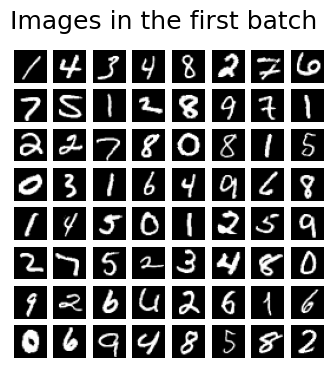

In [48]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break
show_first_batch(loader)

## Fitting the model

In [51]:
#wandb_logger = WandbLogger(project="ddpm-lightning")

cond_ddpm = CondDDPM(ContextUnet(1))
trainer = pl.Trainer(max_epochs=1)
trainer.fit(cond_ddpm, loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type        | Params
------------------------------------------------
0 | noise_predictor | ContextUnet | 26.3 M
1 | criterion       | MSELoss     | 0     
------------------------------------------------
26.3 M    Trainable params
0         Non-trainable params
26.3 M    Total params
105.245   Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniforge/base/envs/pl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s] ---- devices ----
x_0: mps:0
alpha_bars: cpu
noise: mps:0


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!